# Part 3: Finer-Grained Annotation and Versioning

Now that we've learned how to use Flor's extended syntax, we will annotate and version the experiment we have been developing to capture more detailed context about the inputs, code and outputs.

Goals of this notebook:
- Factor our monolithic training script into 3 encapsulated Flor Actions, which pass Artifacts and Literals between them that can be tracked by Flor
- Connect our Actions and Artifacts into a *Flor Plan* workflow DAG
- See how previously derived Artifacts can be reused without rerunning monolithic scripts
- Query Flor's automatically-tracked context to identify and serve our best model so far

## Prepare your environment before starting the activities.

As usual, we're going to start by importing Flor and letting it know the name of our notebook.

In [1]:
# Import Flor
import flor

# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial_3.ipynb')

## We'll provide Flor annotations for all our code in advance

Before we can put together a multi-step experiment in Flor, we need to define the individual Flor functions for each step. The next 3 code cells correspond to 3 Flor actions that we will compose into a *Flor plan* below.

Our first action, shown in the next cell, takes care of splitting the data. `split` is our first "encapsulated" Flor function, and it's useful to spend some time understanding its arguments and how they are used. When we compose `split` in our Flor plan below, we'll see that:
- `intermediate_X` and `intermediate_y` are input Flor Artifacts -- references to files (of data). The `split` routine makes standard Python I/O calls on these (lines 7-14, 19-27) as it would with any file handles, but Flor is able to track the versions of these files during each experiment run.
- `test_size` and `random_state` are input Flor Literals -- passed by value. Note that both of these Literals are passed in the subroutine call to `train_test_split` in Line 17; Flor will be able to track the versions of these Literals as they pass through code during an experiment run. 
- `X_train`, `X_test`, `y_train` and `y_test` are Flor Artifacts that represent the *output* of this function; again they will be tracked by Flor in each experiment run.

In [2]:
@flor.func
def split(intermediate_X, intermediate_y, test_size, random_state, 
          X_train, X_test, y_train, y_test, **kwargs):
    import json
    from sklearn.model_selection import train_test_split
    
    # Read the inputs
    with open(intermediate_X) as json_data:
        X = json.load(json_data)
        json_data.close()
        
    with open(intermediate_y) as json_data:
        y = json.load(json_data)
        json_data.close()
        
    # Split the data
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Write the outputs
    with open(X_train, 'w') as f:
        json.dump(X_tr, f)
    with open(X_test, 'w') as f:
        json.dump(X_te, f)
    with open(y_train, 'w') as f:
        json.dump(y_tr, f)
    with open(y_test, 'w') as f:
        json.dump(y_te, f)

In the next cell, notice the input parameters include `X_train` and `y_train`, which we will use to pass in the output Artifacts from the previous cell's `split` function. `model` and `vectorizer` are output Artifacts of the `train` function below; they are written into files in Lines 26-30, containing serialized Python objects that will also be tracked by Flor.

In [3]:
@flor.func
def train(X_train, y_train, n_estimators, max_depth, model, vectorizer, **kwargs):
    import pandas as pd
    import json
    import cloudpickle

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.ensemble import RandomForestClassifier
    
    # Read the inputs
    with open(X_train, 'r') as f:
        X_tr = json.load(f)
    with open(y_train, 'r') as f:
        y_tr = json.load(f)
    
    # Fit the vectorizer
    vec = TfidfVectorizer()
    vec.fit(X_tr)
    
    # Transform the training data
    X_tr = vec.transform(X_tr)
    
    # Train the model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth).fit(X_tr, y_tr)
    
    # Write the output
    with open(model, 'wb') as f:
        cloudpickle.dump(clf, f)
    with open(vectorizer, 'wb') as f:
        cloudpickle.dump(vec, f)

Finally, the `eval` function below takes as arguments the test data, model, and vectorizer Artifacts and evaluates the model we just trained. Note line 24: the `return` of a Flor func is a Flor Literal that is tracked in each experiment run. 

In [4]:
@flor.func
def eval(X_test, y_test, model, vectorizer, **kwargs):
    import pandas as pd
    import json
    import cloudpickle
    
    # Read the inputs
    with open(X_test, 'r') as f:
        X_te = json.load(f)
    with open(y_test, 'r') as f:
        y_te = json.load(f)
    with open(model, 'rb') as f:
        clf = cloudpickle.load(f)
    with open(vectorizer, 'rb') as f:
        vec = cloudpickle.load(f)
    
    # Test the model
    X_te = vec.transform(X_te)
    score = clf.score(X_te, y_te)
    
    print(score)
    
    # Return the score
    return {'score': score}

## Now let's build a detailed Flor Plan

Now that we've written the code, and we know which resources to read (Bob's latest preprocessed data), we can specify the Flor Plan, exposing all hyper-parameters and intermediate Artifacts. 

Look at lines 13-19; they wire the `split` Action into the Flor plan with its inputs and outputs. The inputs are declared in the `in_artifacts` parameter to `ex.action` in line 13. Each of lines 14-17 specifies an output Artifact; we connect that Artifact to a specific argument of the `split` Action by (a) referencing `do_split` in the `parent` argument to `ex.artifact`, and (b) declaring the desired argument of `split` via the `name` argument of `ex.artifact`.

A similar pattern wires in `train` in lines 19-21, and `eval` in lines 23-24.

In [5]:
with flor.Experiment('bob_preproc') as bob, flor.Experiment('risecamp_demo') as ex:
    # This is how we tell Flor we will be using Bob's derived artifacts
    data_x = bob.artifact('data_clean_X.json', 'intermediate_X', label="second_preproc")
    data_y = bob.artifact('data_clean_y.json', 'intermediate_y', label="second_preproc")
    
    # Here we declare all the static literals
    random_state = ex.literal(92, 'random_state')
    test_size = ex.literal(0.20, 'test_size')
    n_estimators = ex.literal(7, 'n_estimators') 
    max_depth = ex.literal(100, 'max_depth')
    
    # Now we connect the Flor Plan
    do_split = ex.action(func=split, in_artifacts=[data_x, data_y, test_size, random_state])
    X_train = ex.artifact(loc='X_train.json', name='X_train', parent=do_split)
    X_test = ex.artifact(loc='X_test.json', name='X_test', parent=do_split)
    y_train = ex.artifact(loc='y_train.json', name='y_train', parent=do_split)
    y_test = ex.artifact(loc='y_test.json', name='y_test', parent=do_split)
    
    do_train = ex.action(func=train, in_artifacts=[X_train, y_train, n_estimators, max_depth])
    model = ex.artifact(loc='model.pkl', name='model', parent=do_train)
    vectorizer = ex.artifact(loc='vectorizer.pkl', name='vectorizer', parent=do_train)
    
    do_eval = ex.action(func=eval, in_artifacts=[X_test, y_test, model, vectorizer])
    score = ex.literal(name='score', parent=do_eval)

Prior to this point, we only saw Flor Plans with a single action. Now we can call `score.plot()` to see our more involved Flor Plan.  In the plot generated by the next cell, rectangles correspond to Artifacts, which the user is responsible for reading/writing, but which Flor automatically tracks and versions. The underlined names correspond to literals, which Flor both stores and tracks across runs. 

The distinction between Artifacts and Literals can sometimes feel arbitrary. As a rule of thumb, if an object is relatively small (in bytes) and can be serialized as a string without losing information, then it can be a Literal. Otherwise, it's best to represent it as an Artifact.

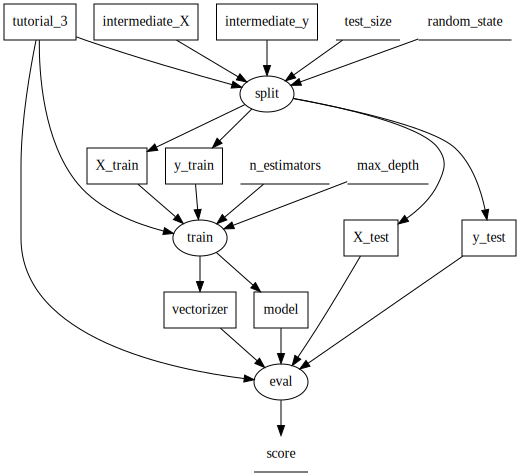

In [6]:
score.plot()

Now we pull the score to execute the experiment we just defined.

In [7]:
score.pull('seventh_pull')

0.7567


We see the score is still hovering around 75%.

In [8]:
flor.Experiment('risecamp_demo').summarize()

,label,score,random_state,n_estimators,test_size,max_depth,tutorial_3,y_train,y_test,X_test,intermediate_X,intermediate_y,X_train,vectorizer,model,tutorial_2,tutorial_1
0,seventh_pull,0.7567,92.0,7.0,0.2,100.0,tutorial_3_140066367161288.ipynb,y_train_140066367161736.json,y_test_140066367162072.json,X_test_140066367162408.json,data_clean_X_112394722104.json,data_clean_y_112394719416.json,X_train_140066367161232.json,vectorizer_140066367160896.pkl,model_140066367160728.pkl,NaN,NaN
1,sixth_pull,0.7460,NaN,7.0,NaN,100.0,NaN,NaN,NaN,NaN,data_clean_X_112394722104.json,data_clean_y_112394719416.json,NaN,NaN,NaN,tutorial_2_140276092881104.ipynb,NaN
2,fifth_pull,0.6520,NaN,7.0,NaN,100.0,NaN,NaN,NaN,NaN,data_clean_X_111988783760.json,data_clean_y_111988784208.json,NaN,NaN,NaN,tutorial_2_140276092876728.ipynb,NaN
3,2018-10-12_00-42-25,0.7331,NaN,7.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_1_139742951853808.ipynb
4,2018-10-12_00-42-25,0.7002,NaN,7.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_1_139742951853808.ipynb
5,2018-10-12_00-38-58,0.7089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_1_139742745119600.ipynb
6,2018-10-12_00-37-29,0.7044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_1_139741553533616.ipynb


Notice how the finer-grained annotations resulted in more detailed information about our experimental pipeline. The Flor plan itself is a more helpful description of the high-level intent of the code, and serves as a form of documentation. Also, because Flor is tracking intermediate Artifacts and Literals, the `summarize` call is able to provide more information about what is computed and stored along the way. These intermediate Artifacts and Literals are automatically versioned by Flor, and can be individually examined and `diff`ed across runs for more granular tracking of changes across runs.

## Reusing models from previous Flor experiments
Another benefit of exposing the intermediate Artifacts and Literals between smaller Actions is that previously-computer intermediate objects can be reused without requiring recomputation. In the next cells we will reuse the output Artifacts from our earlier runs, examine them, and "serve" them in a toy application.

## Checkout best model and serve it
Here, we're going to retrieve the model and vectorizer we just fitted with Flor. Lines 1-3 of the next cell declare a Flor experiment in the extended syntax. In lines 4-5, rather than calling the Flor `pull` method (which runs an experiment and stores the output) we use Flor's `peek` method to build each Artifact and load it into a Python variable.

In [9]:
with flor.Experiment('risecamp_demo') as ex:
    model = ex.artifact('model.pkl', 'model', label='seventh_pull')
    vectorizer = ex.artifact('vectorizer.pkl', 'vectorizer', label='seventh_pull')
model = model.peek()
vec = vectorizer.peek()

Now we deploy the model into a toy application that tries to predict the sentiment from your phrases. Try out some phrases and see how the model does!  Enter `nothing` to exit.

In [ ]:
PROMPT = "What's on your mind? "

phrase = input(PROMPT)
while phrase[0:len('nothing')].lower() != 'nothing':
    phrase = vec.transform([phrase,])
    positive = model.predict(phrase)
    if positive:
        print('Happy to hear that!\n'.format(phrase))
    else:
        print("Sorry about that...\n")
    phrase = input(PROMPT)
print('you said nothing.')

# Final Thoughts
To summarize our three notebooks, we've been reminded of the value of annotating and versioning experiments, and witnessed how Flor can automate these responsibilities with as few as 3 lines of code. Moreover, when finer-grained tracking is desired, Flor is able to capture more meta-data and store derived artifacts for future retrieval. Flor enables experiment interpretation and re-using artifacts across experiments.